# Visual Language Models (VLMs) Lab Exercise
## ITAI 1378 - Module 08

---

### Lab Overview

Welcome to the VLM Lab! In this hands-on exercise, you'll explore the fascinating world of Visual Language Models - AI systems that can understand and reason about both images and text.

**Estimated Time:** 2-2.5 hours

### Learning Outcomes

By the end of this lab, you will be able to:

1. **Understand VLMs and Their Architectures**: Explain how VLMs work and differentiate between major architectural approaches (CLIP, BLIP, LLaVA)
2. **Understand Applications of VLMs**: Identify and implement practical applications like image search, captioning, and visual question answering
3. **Evaluate and Apply**: Analyze trade-offs between different VLM approaches and make informed decisions for real-world problems

### Two Paths Available

This lab provides **two implementation paths** based on your available compute resources:

- **🚀 Path A (Limited Compute)**: Uses CLIP and smaller models - runs on CPU or basic GPU
- **⚡ Path B (More Resources)**: Uses BLIP-2 and larger models - requires GPU with 8GB+ VRAM

**You only need to complete ONE path**, but you're welcome to explore both!

---

### 🤖 Using AI Assistants Effectively

**You are encouraged to use AI assistants (ChatGPT, Claude, etc.) for coding help!** However, use them wisely:

✅ **Good uses:**
- Understanding error messages
- Learning Python syntax and concepts
- Debugging code that isn't working
- Explaining what a code block does

❌ **Avoid:**
- Copy-pasting reflection questions into AI without thinking first
- Having AI write your conceptual answers
- Using AI to skip the learning process

**Remember**: The reflection questions are designed to make you think critically. Write your own thoughts first, then optionally discuss with AI to refine your understanding.

---

## Section 0: Environment Setup

Let's start by setting up our environment and installing the necessary libraries.

### 📚 For Python Beginners

- **Libraries/Packages**: Collections of pre-written code that add functionality
- **pip**: Python's package installer (like an app store for code)
- **!** in Jupyter: Runs a command in the terminal, not in Python
- **import**: Brings a library's functionality into your code

**💡 Tip**: If installation fails, try restarting the kernel (Kernel → Restart) and running again.

In [5]:
# Install required packages
# This might take 3-5 minutes - be patient!

!pip install -q torch torchvision transformers pillow matplotlib datasets
!pip install -q ftfy regex tqdm
!pip install -q sentencepiece  # For some models

print("✓ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
✓ Installation complete!


In [4]:
# Import libraries
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForConditionalGeneration, BlipForQuestionAnswering
from datasets import load_dataset
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU - consider using Path A (Limited Compute)")

Using device: cuda
GPU: Tesla T4
Available GPU memory: 15.83 GB


### ✅ Knowledge Check 1: Environment

**Question**: What is the purpose of checking for GPU availability in the code above? Why might some VLM operations be slow on CPU?

**Your Answer**:
_(Type your answer here)_

---

## Section 1: Understanding VLM Fundamentals

Before we dive into code, let's explore the core concepts that make VLMs work.

### 🎯 Recall: The Three Building Blocks

Every VLM consists of three core components:

1. **Vision Encoder** 🖼️ - Converts images into numerical representations (embeddings)
2. **Language Model** 🧠 - Understands and generates text
3. **The Bridge** 🌉 - Connects vision and language (via cross-attention or projection)

### The Magic of Shared Embedding Space

The key insight: **Both images and text are converted into vectors in the same high-dimensional space**. This allows us to:

- Measure how similar an image is to a text description
- Find images that match a text query
- Generate text descriptions of images

Let's visualize this concept!

In [9]:
# Helper function to load images from URLs
def load_image_from_url(url):
    """Load an image from a URL."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Helper function to display images
def show_images(images, titles=None, cols=3):
    """Display multiple images in a grid."""
    n_images = len(images)
    # If there are no images, print a message and exit the function.
    if n_images == 0:
        print("No images to display.")
        return
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx, img in enumerate(images):
        row = idx // cols
        col = idx % cols
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if titles and idx < len(titles):
            axes[row, col].set_title(titles[idx], fontsize=12, wrap=True)

    # Hide empty subplots
    for idx in range(n_images, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

print("✓ Helper functions defined!")

✓ Helper functions defined!


### 🤔 Reflection Question 1: The Alignment Problem

In the lecture, we discussed the "alignment problem" - the challenge of creating a shared representation space where visual and textual concepts are aligned.

**Question**: Why is it challenging to align vision and language? Think about:
- How images and text are fundamentally different
- What makes the word "cat" similar to a picture of a cat in a meaningful way
- What information might be lost or gained when converting each modality to embeddings

**Your Answer**:

 _It is challenging to align vision and language because images and text are fundamentally different. images are represented to the computer in the format of pixel matrixes and text are represented to the computer in the form of encoded characters. The challenge resulting from this structural difference is called the Representation Gap. So, it would take more resources, so to speak to convey the same subject in an image form. For example, a picture of a cat vs typing the word 'cat'._

---

## Section 2: Exploring VLM Architectures

Now let's explore the different architectural approaches discussed in the lecture.

### Architecture Comparison (From Lecture)

| Architecture | Approach | Key Feature | Best For |
|-------------|----------|-------------|----------|
| CLIP | Contrastive | Zero-shot classification | Simple classification, search |
| BLIP | Projector + Gen | Bootstrapping data | VQA, Captioning |
| LLaVA | Projector | Instruction tuning | Multimodal chat, reasoning |
| Flamingo | Adapter | Few-shot learning | Tasks with limited data |
| GPT-4V | Integrated | State-of-the-art | Complex reasoning, analysis |

### Choose Your Path!

- **Path A (Limited Compute)**: We'll use **CLIP** - excellent for zero-shot tasks, runs on CPU
- **Path B (More Resources)**: We'll use **BLIP-2** - better for generation tasks, needs GPU

---

## 🚀 PATH A: Limited Compute (CLIP)

### Introduction to CLIP

**CLIP (Contrastive Language-Image Pre-training)** was developed by OpenAI and trained on 400 million image-text pairs from the internet.

**Key Innovation**: Contrastive learning
- Given a batch of images and text descriptions
- Learn to match correct pairs (positive examples)
- Push apart incorrect pairs (negative examples)

**Result**: A shared embedding space where similar images and text are close together!

### Applications of CLIP
1. Zero-shot image classification
2. Image-text similarity/search
3. Foundation for other models (like Stable Diffusion)

Let's load CLIP and explore its capabilities.

In [ ]:
# PATH A: Load CLIP model (runs on CPU)
print("Loading CLIP model... (this may take 1-2 minutes)")

model_name = "openai/clip-vit-base-patch32"  # Smaller, faster version
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

# Move to device (GPU if available, CPU otherwise)
clip_model = clip_model.to(device)

print("✓ CLIP model loaded successfully!")
print(f"Model size: ~600MB")
print(f"Embedding dimension: {clip_model.config.projection_dim}")

### 📚 Understanding the Code

- **`from_pretrained()`**: Loads a pre-trained model (saved weights) instead of training from scratch
- **Processor**: Handles pre-processing (resizing images, tokenizing text) to match model's expected input format
- **`.to(device)`**: Moves model to GPU (if available) or keeps on CPU
- **Embedding dimension**: The size of the vector representation (higher = more expressive, but slower)

---

### Experiment 1: Zero-Shot Image Classification

Let's test CLIP's zero-shot classification capability. We'll classify images into categories that CLIP has never explicitly been trained to recognize!

In [ ]:
# Load a sample image from COCO dataset
print("Loading sample images from COCO dataset...")

# Load COCO validation dataset (small subset)
coco_dataset = load_dataset("yerevann/coco-karpathy", split="validation[:20]")  # Just 20 images for speed

# Print the keys available in the dataset object to diagnose the issue
print("Keys available in the dataset:")
print(coco_dataset.features.keys())

# Get a random image index
import random
random_index = random.randint(0, len(coco_dataset) - 1)

# Get the image URL instead of filepath
image_url = coco_dataset[random_index]['url']

print(f"Downloading image from: {image_url}")

# Download and open the image from URL
response = requests.get(image_url)
sample_image = Image.open(BytesIO(response.content))

print(f"Image loaded! Size: {sample_image.size}")

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(sample_image)
plt.axis('off')
plt.title("Sample Image from COCO")
plt.show()

# Fix: sentences might be a list of dicts or a different structure
sentences = coco_dataset[random_index]['sentences']
if isinstance(sentences, list) and len(sentences) > 0:
    if isinstance(sentences[0], dict):
        print(f"Caption: {sentences[0]['raw']}")
    else:
        print(f"Caption: {sentences[0]}")
else:
    print(f"Caption: {sentences}")

In [ ]:
# Zero-shot classification with CLIP
def classify_image_clip(image, text_labels):
    """
    Classify an image using CLIP with provided text labels.

    Args:
        image: PIL Image
        text_labels: List of text descriptions (categories)

    Returns:
        Dictionary with probabilities for each label
    """
    # Process inputs
    inputs = clip_processor(
        text=text_labels,
        images=image,
        return_tensors="pt",
        padding=True
    ).to(device)

    # Get model predictions
    with torch.no_grad():  # Don't compute gradients (faster, uses less memory)
        outputs = clip_model(**inputs)

    # Calculate similarity scores (logits)
    logits_per_image = outputs.logits_per_image

    # Convert to probabilities
    probs = logits_per_image.softmax(dim=1).cpu().numpy()[0]

    # Create results dictionary
    results = {label: prob for label, prob in zip(text_labels, probs)}
    return results

# Test with different categories
categories = [
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a person",
    "a photo of food",
    "a photo of a vehicle"
]

results = classify_image_clip(sample_image, categories)

# Display results
print("\n=== Classification Results ===")
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for label, prob in sorted_results:
    print(f"{label}: {prob:.4f} ({prob*100:.2f}%)")

# Visualize
plt.figure(figsize=(10, 5))
labels = [item[0] for item in sorted_results]
probs = [item[1] for item in sorted_results]
plt.barh(labels, probs)
plt.xlabel('Probability')
plt.title('CLIP Zero-Shot Classification Results')
plt.tight_layout()
plt.show()

### 💡 What Just Happened?

1. We gave CLIP an image and several text descriptions
2. CLIP computed **embeddings** (vector representations) for both the image and each text description
3. It measured the **similarity** between the image embedding and each text embedding
4. Higher similarity = higher probability that the text describes the image

**The Magic**: CLIP was never explicitly trained on these specific categories! It learned general image-text relationships from 400M examples.

---

### ✅ Knowledge Check 2: Zero-Shot Learning

**Question 1**: What does "zero-shot" mean in the context of CLIP? Why is this capability valuable?

**Your Answer**:
_(Type your answer here)_

**Question 2**: Look at the classification results above. Try modifying the `categories` list to test different classifications. What happens if you make the categories more specific (e.g., "a golden retriever" vs "a photo of a dog")?

**Your Observations**:
_(Try it and write what you notice)_

---

### Experiment 2: Image-Text Retrieval

Now let's use CLIP for **image search** - finding images that match a text query. This is similar to Google Images or Pinterest visual search!

In [2]:
# Load multiple images from COCO
num_images = 12
print(f"Loading {num_images} images from COCO...")

images = []
captions = []

for i in range(min(num_images, len(coco_dataset))):
    # Download image from URL
    image_url = coco_dataset[i]['url']
    try:
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content))
        images.append(img)

        # Get caption
        sentences = coco_dataset[i]['sentences']
        if isinstance(sentences, list) and len(sentences) > 0:
            if isinstance(sentences[0], dict):
                captions.append(sentences[0]['raw'])
            else:
                captions.append(sentences[0])
        else:
            captions.append("No caption available")
    except Exception as e:
        print(f"Failed to load image {i}: {e}")
        continue

print(f"✓ Loaded {len(images)} images")

# Display the images
show_images(images, titles=[f"Image {i}" for i in range(len(images))], cols=4)

Loading 12 images from COCO...


NameError: name 'coco_dataset' is not defined

In [ ]:
# Image search function
def search_images_clip(images, text_query, top_k=3):
    """
    Search for images that match a text query using CLIP.

    Args:
        images: List of PIL Images
        text_query: Text description to search for
        top_k: Number of top results to return

    Returns:
        List of (index, score) tuples for top matches
    """
    # Process all images and the text query
    inputs = clip_processor(
        text=[text_query],
        images=images,
        return_tensors="pt",
        padding=True
    ).to(device)

    # Get embeddings
    with torch.no_grad():
        outputs = clip_model(**inputs)

    # Calculate similarity scores
    logits_per_text = outputs.logits_per_text  # Shape: [1, num_images]
    scores = logits_per_text[0].cpu().numpy()

    # Get top-k indices
    top_indices = np.argsort(scores)[::-1][:top_k]
    top_scores = scores[top_indices]

    return list(zip(top_indices, top_scores))

# Try different search queries
queries = [
    "people playing sports",
    "animals in nature",
    "food on a table"
]

for query in queries:
    print(f"\n=== Searching for: '{query}' ===")
    results = search_images_clip(images, query, top_k=3)

    # Display results
    top_images = [images[idx] for idx, _ in results]
    top_titles = [f"Rank {i+1}\nScore: {score:.3f}\nActual: {captions[idx][:50]}..."
                  for i, (idx, score) in enumerate(results)]

    show_images(top_images, titles=top_titles, cols=3)

### 🤔 Reflection Question 2: Search Quality

Look at the search results for different queries.

**Question**:
1. How well did CLIP perform on these searches? Were the top results relevant?
2. Try creating your own search queries in the code above. What types of queries work well vs. poorly?
3. Why might some queries be harder for CLIP than others? Think about:
   - Abstract concepts vs. concrete objects
   - Relationships between objects
   - Fine-grained details

**Your Analysis**:
_(Write your observations and reasoning)_

---

### Experiment 3: Understanding Embeddings

Let's peek "under the hood" and visualize what the embedding space looks like.

In [ ]:
# Extract embeddings for images and text
def get_clip_embeddings(images, texts):
    """
    Get CLIP embeddings for images and texts.

    Returns:
        image_embeddings: numpy array of shape [num_images, embedding_dim]
        text_embeddings: numpy array of shape [num_texts, embedding_dim]
    """
    # Process images
    image_inputs = clip_processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**image_inputs)

    # Process text
    text_inputs = clip_processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)

    # Normalize embeddings (CLIP uses cosine similarity)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    return image_features.cpu().numpy(), text_features.cpu().numpy()

# Get embeddings
sample_texts = [
    "a photo of a cat",
    "a photo of a dog",
    "people playing sports",
    "delicious food"
]

image_embeds, text_embeds = get_clip_embeddings(images[:8], sample_texts)

print(f"Image embeddings shape: {image_embeds.shape}")
print(f"Text embeddings shape: {text_embeds.shape}")
print(f"\nEach item is represented by a {image_embeds.shape[1]}-dimensional vector!")

In [ ]:
# Visualize similarity matrix
similarity_matrix = image_embeds @ text_embeds.T  # Matrix multiplication

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Text Descriptions')
plt.ylabel('Images')
plt.xticks(range(len(sample_texts)), sample_texts, rotation=45, ha='right')
plt.yticks(range(len(images[:8])), [f"Image {i}" for i in range(8)])
plt.title('Image-Text Similarity Matrix (CLIP Embeddings)')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- Brighter colors = higher similarity between image and text")
print("- Each cell shows how well an image matches a text description")
print("- This is the core of how CLIP performs zero-shot classification!")

### ✅ Knowledge Check 3: Embeddings

**Question 1**: What is an embedding, and why do we need them? (Hint: Think about how computers represent things)

**Your Answer**:
_(Type your answer here)_

**Question 2**: Look at the similarity matrix above. What does a high similarity score (bright color) tell you about the relationship between an image and a text description?

**Your Answer**:
_(Type your answer here)_

**Question 3**: CLIP uses **cosine similarity** (measuring the angle between vectors) rather than Euclidean distance. Why might angle be a better measure than distance for semantic similarity?

**Your Answer**:
_(Type your answer here)_

---

### 🎯 PATH A CHECKPOINT

**Congratulations!** You've completed the core CLIP experiments.

**What you've learned so far:**
- ✅ How CLIP creates a shared embedding space for images and text
- ✅ Zero-shot classification without task-specific training
- ✅ Image search using text queries
- ✅ How embeddings and similarity scores work

**Continue to Section 3** for fine-tuning and advanced topics!

---

## ⚡ PATH B: More Resources (BLIP/BLIP-2)

### Introduction to BLIP

**BLIP (Bootstrapping Language-Image Pre-training)** goes beyond CLIP by adding **generation capabilities**.

**Key Features:**
- **Understands** images (like CLIP)
- **Generates** captions and answers questions (unlike CLIP)
- **Bootstraps** training data by generating and filtering its own captions

**Architecture:**
- Vision Encoder (similar to CLIP)
- Q-Former: A "bridge" that connects vision to language
- Language Model: Generates text

**Applications:**
1. Image captioning
2. Visual Question Answering (VQA)
3. Image-text retrieval

⚠️ **Note**: BLIP requires more computational resources than CLIP. Make sure you have a GPU with at least 8GB VRAM.

In [6]:
# PATH B: Load BLIP model for image captioning
print("Loading BLIP model... (this may take 2-3 minutes)")

# Check if we have enough GPU memory
if device == "cpu":
    print("⚠️ Warning: Running BLIP on CPU will be VERY slow.")
    print("Consider using Path A (CLIP) instead, or use a GPU environment.")
    # Optionally, uncomment the line below to prevent loading on CPU
    # raise Exception("BLIP requires GPU. Please use Path A or switch to a GPU environment.")

# Load model for captioning
blip_caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Load model for VQA
blip_vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

print("✓ BLIP models loaded successfully!")
print(f"Caption model size: ~990MB")
print(f"VQA model size: ~990MB")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP model... (this may take 2-3 minutes)


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

✓ BLIP models loaded successfully!
Caption model size: ~990MB
VQA model size: ~990MB


### 📚 Understanding the Code

- **Two separate models**: One for captioning, one for VQA (different tasks, different fine-tuning)
- **BlipForConditionalGeneration**: A model that can generate text (captions) from images
- **BlipForQuestionAnswering**: Specialized for answering questions about images
- These are **task-specific** models, unlike CLIP which is more general-purpose

---

Loading sample images from COCO dataset...
✓ Loaded 12 images


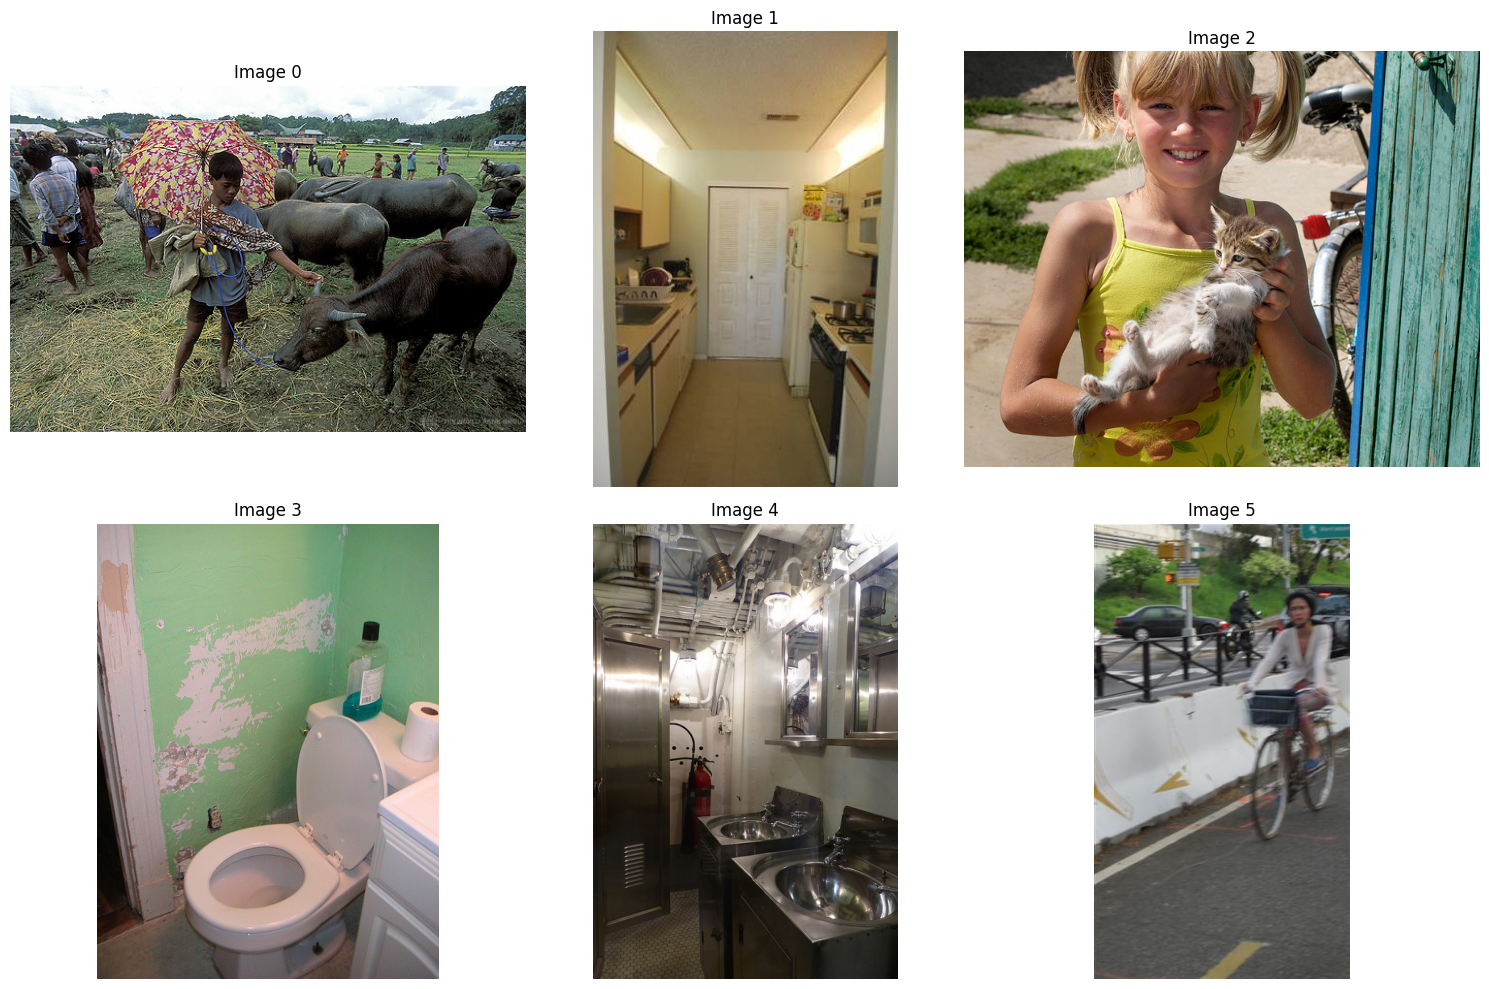

In [19]:
# Load sample images (same as Path A)
print("Loading sample images from COCO dataset...")
coco_dataset = load_dataset("yerevann/coco-karpathy", split="validation[:20]")

images_pathb = []
captions_pathb = []

for i in range(12):
    # Download image from URL
    image_url = coco_dataset[i]['url']
    try:
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content))
        images_pathb.append(img)

        # Get caption
        sentences = coco_dataset[i]['sentences']
        if isinstance(sentences, list) and len(sentences) > 0:
            if isinstance(sentences[0], dict):
                captions_pathb.append(sentences[0]['raw'])
            else:
                captions_pathb.append(sentences[0])
        else:
            captions_pathb.append("No caption available")
    except Exception as e:
        print(f"Failed to load image {i}: {e}")
        continue

print(f"✓ Loaded {len(images_pathb)} images")
show_images(images_pathb[:6], titles=[f"Image {i}" for i in range(6)], cols=3)

### Experiment 1: Image Captioning

Let's generate natural language descriptions of images!


=== Generating Captions ===

Image 1:
Generated: a group of people
Actual:    A child holding a flowered umbrella and petting a yak.

Image 2:
Generated: a kitchen with a sink and a stove
Actual:    A narrow kitchen filled with appliances and cooking utensils.

Image 3:
Generated: a young girl holding a cat
Actual:    A little girl holding a kitten next to a blue fence.

Image 4:
Generated: a bathroom with a toilet and a green wall
Actual:    A toilet sitting in a bathroom next to a sink.

Image 5:
Generated: a kitchen with a sink and a sink
Actual:    There are two sinks next to two mirrors.

Image 6:
Generated: a woman riding a bike down a street
Actual:    A woman rides a bicycle on a road next to the median.


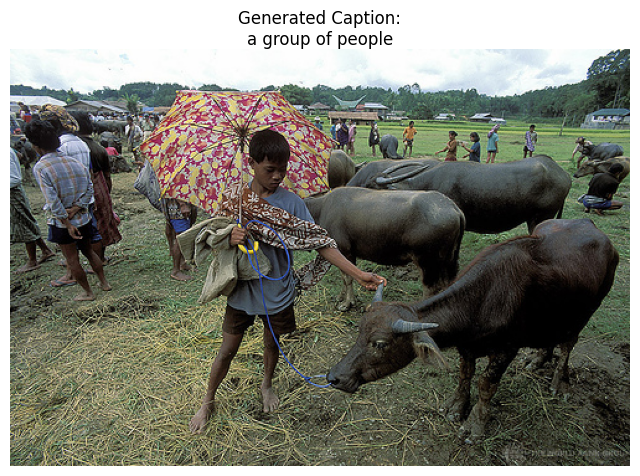

In [8]:
# Generate captions
def generate_caption_blip(image):
    """
    Generate a caption for an image using BLIP.

    Args:
        image: PIL Image

    Returns:
        Generated caption (string)
    """
    # Process image
    inputs = blip_caption_processor(images=image, return_tensors="pt").to(device)

    # Generate caption
    with torch.no_grad():
        output = blip_caption_model.generate(**inputs, max_length=50)

    # Decode the output
    caption = blip_caption_processor.decode(output[0], skip_special_tokens=True)
    return caption

# Test on several images
print("\n=== Generating Captions ===")
for i in range(6):
    image = images_pathb[i]
    generated_caption = generate_caption_blip(image)
    actual_caption = captions_pathb[i]

    print(f"\nImage {i+1}:")
    print(f"Generated: {generated_caption}")
    print(f"Actual:    {actual_caption}")

# Visualize
sample_idx = 0
plt.figure(figsize=(8, 6))
plt.imshow(images_pathb[sample_idx])
plt.axis('off')
generated = generate_caption_blip(images_pathb[sample_idx])
plt.title(f"Generated Caption:\n{generated}", fontsize=12, wrap=True)
plt.show()

### 💡 What Just Happened?

1. BLIP's vision encoder converted the image into embeddings
2. The Q-Former "queries" these embeddings to extract relevant information
3. The language model generates text, token by token, based on the visual information
4. This is **generative** - BLIP is creating new text, not just classifying!

**Key Difference from CLIP**: CLIP can only match/score existing text. BLIP can generate new descriptions.

---

### ✅ Knowledge Check 2 (Path B): Generation vs. Classification

**Question 1**: What is the fundamental difference between CLIP's zero-shot classification and BLIP's caption generation? Think about their outputs.

**Your Answer**:
_The fundamentall difference between CLIP's zero-shot classification and BLIP's caption generation is that CLIP's output is simple classification by matching pre-existing image to pre-existing text, and BLIP's output is new generated text._

**Question 2**: Look at the generated captions vs. actual captions. How well did BLIP do? What kinds of details did it capture? What did it miss?

**Your Analysis**:
_BLIP did well for 5 out of the 6 images. The only one that was not accurate was the photo of the boy petting the ox. It focused on the group of people in the background rather than the main subject (boy and ox). Also, it did not get the correct description of the type of animal._

---

### Experiment 2: Visual Question Answering (VQA)

Now let's ask questions about images! This is more interactive than captioning.

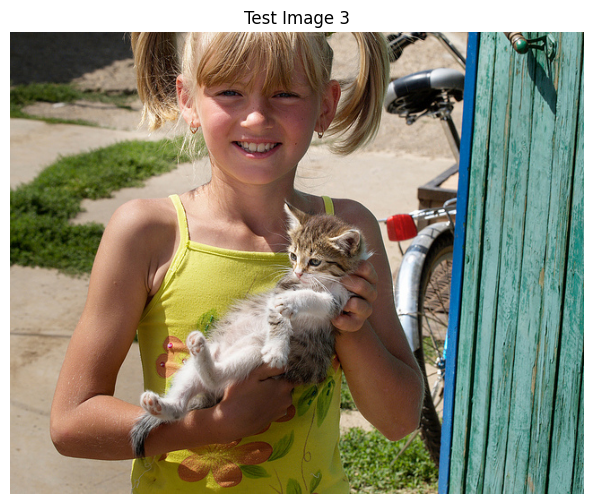


Actual caption: A little girl holding a kitten next to a blue fence.

=== Visual Question Answering ===
Q: What is in the image?
A: girl holding cat

Q: What color is the main object?
A: green

Q: Is this indoors or outdoors?
A: outdoors

Q: How many people are in the image?
A: one

Q: What is the person doing?
A: holding kitten

Q: How many ears does the cat have?
A: two

Q: What is the object behind the girl, to the right?
A: bicycle

Q: Where is the bicycle?
A: behind girl

Q: Is the girl crying?
A: no

Q: How many animals is in the picture?
A: 2



In [9]:
# VQA function
def answer_question_blip(image, question):
    """
    Answer a question about an image using BLIP.

    Args:
        image: PIL Image
        question: Question string

    Returns:
        Answer string
    """
    # Process image and question
    inputs = blip_vqa_processor(images=image, text=question, return_tensors="pt").to(device)

    # Generate answer
    with torch.no_grad():
        output = blip_vqa_model.generate(**inputs, max_length=20)

    # Decode the answer
    answer = blip_vqa_processor.decode(output[0], skip_special_tokens=True)
    return answer

# Test with different questions
test_image_idx = 2
test_image = images_pathb[test_image_idx]

questions = [
    "What is in the image?",
    "What color is the main object?",
    "Is this indoors or outdoors?",
    "How many people are in the image?",
    "What is the person doing?",
    "How many ears does the cat have?",
    "What is the object behind the girl, to the right?",
    "Where is the bicycle?",
    "Is the girl crying?",
    "How many animals is in the picture?"
]

# Display image
plt.figure(figsize=(8, 6))
plt.imshow(test_image)
plt.axis('off')
plt.title(f"Test Image {test_image_idx+1}")
plt.show()

print(f"\nActual caption: {captions_pathb[test_image_idx]}")
print("\n=== Visual Question Answering ===")
for question in questions:
    answer = answer_question_blip(test_image, question)
    print(f"Q: {question}")
    print(f"A: {answer}")
    print()

### 🤔 Reflection Question 2 (Path B): VQA Capabilities

**Question**:
1. Look at the Q&A pairs above. Which types of questions did BLIP answer well? Which were challenging?
2. Try adding your own questions in the code above. What types of reasoning does VQA require?
   - Simple object detection ("What is in the image?")
   - Counting ("How many...?")
   - Spatial relationships ("Where is...?")
   - Contextual understanding ("Why is...?")
3. What are the limitations you notice? Think about hallucinations mentioned in the lecture.

**Your Analysis**:
_BLIP answered all the questions well except for my question about "how many animals is in the picture". It answered 2. Apparently, BLIP classified humans as animals. I think this is a case of hallucination._

---

### Experiment 3: Comparing Captioning Approaches

BLIP can generate captions in different ways. Let's explore!

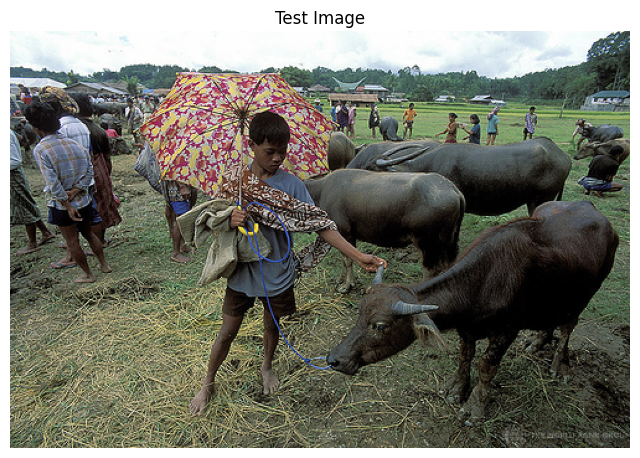


=== Conditional Captioning ===
Prompt: ''
Caption: a group of people

Prompt: 'a photo of'
Caption: a photo of a man feeding a group of animals

Prompt: 'this image shows'
Caption: this image shows a man with an umbrella and a bunch of animals

Prompt: 'in this scene,the boy is'
Caption: in this scene, the boy is holding an umbrella

Prompt: 'the oxes are'
Caption: the oxes are eating hay

Prompt: 'the people are'
Caption: the people are out in the daytime



In [10]:
# Conditional captioning with BLIP
def generate_conditional_caption(image, prompt):
    """
    Generate a caption with a text prompt/prefix.

    Args:
        image: PIL Image
        prompt: Text prompt to condition the generation

    Returns:
        Generated caption
    """
    # Process with text prompt
    inputs = blip_caption_processor(images=image, text=prompt, return_tensors="pt").to(device)

    # Generate
    with torch.no_grad():
        output = blip_caption_model.generate(**inputs, max_length=50)

    caption = blip_caption_processor.decode(output[0], skip_special_tokens=True)
    return caption

# Test with different prompts
test_img = images_pathb[0]

prompts = [
    "",  # Unconditional
    "a photo of",
    "this image shows",
    "in this scene,"
    "the boy is",
    "the oxes are",
    "the people are"
]

plt.figure(figsize=(8, 6))
plt.imshow(test_img)
plt.axis('off')
plt.title("Test Image")
plt.show()

print("\n=== Conditional Captioning ===")
for prompt in prompts:
    caption = generate_conditional_caption(test_img, prompt)
    print(f"Prompt: '{prompt}'")
    print(f"Caption: {caption}")
    print()

### ✅ Knowledge Check 3 (Path B): Conditional Generation

**Question**: How does the text prompt influence the generated caption? Why might conditional generation be useful in real applications?

**Your Answer**:
_The text prompt influences the generated caption in that the more precise the prompt, the more precise the description. I tested this with prompting "the oxes are" and "the people are" and it gave me more interesting description (and still accurate) descriptions than the default prompts._

---

### 🎯 PATH B CHECKPOINT

**Congratulations!** You've completed the core BLIP experiments.

**What you've learned so far:**
- ✅ How BLIP generates captions from images
- ✅ Visual Question Answering (VQA) capabilities
- ✅ Conditional vs. unconditional generation
- ✅ Comparing understanding vs. generation models

**Continue to Section 3** for fine-tuning and advanced topics!

---

## Section 3: Introduction to Fine-Tuning

So far, we've used **pre-trained** models. But what if we want to adapt them to our specific use case?

### What is Fine-Tuning?

**Fine-tuning** means taking a pre-trained model and training it further on a specific dataset or task.

**Why Fine-Tune?**
- Improve performance on your specific domain (e.g., medical images, product photos)
- Adapt to your specific task (e.g., detecting specific objects)
- Handle specialized vocabulary or visual concepts

**The Trade-off:**
- ✅ Better performance on your task
- ❌ Requires labeled data
- ❌ Requires computational resources
- ❌ Risk of overfitting (losing general knowledge)

### Fine-Tuning Strategies

1. **Full Fine-Tuning**: Update all model parameters (expensive, powerful)
2. **Partial Fine-Tuning**: Only update some layers (more efficient)
3. **Adapter Layers**: Add small trainable modules (very efficient)
4. **Prompt Tuning**: Learn optimal text prompts (minimal parameters)

In this lab, we'll do a **simple demonstration** of fine-tuning concepts rather than full training (which would take hours).

---

### 🤔 Reflection Question 3: Fine-Tuning Considerations

Before we proceed, think about this scenario:

**Scenario**: A hospital wants to use a VLM to help radiologists by automatically generating descriptions of X-ray images.

**Questions**:
1. Would a pre-trained model like BLIP (trained on general internet images) work well out-of-the-box? Why or why not?  
2. What challenges would you face in fine-tuning a VLM for this task?
3. What kind of data would you need? How much?
4. What are the ethical considerations? (Think back to the lecture on VLM limitations)



**Your Answer**:
1.   It would not work well out-of-the-box because generating description for X-ray images require high specificity and accuracy. Since the model was trained on general internet images, it would not have the capability to understand and generate the X-ray images.

2.    One challenge would be the need for a large data set of images, having different kinds of X-rays of different body parts/bones. Needing patient consent in order to gather this many images would be a challenge as well since people may be wary about allowing their medical data being used to train AI.

3.   In this scenario, one would need X-ray images representing the control group (normal, healthy organs) and images representing the common pathologies, all with different angles, etc.

4.   The most pressing ethical consideration would be protecting patient privacy in accordance with HIPAA. One would need to have comprehensive guidelines in place describing who is allowed to have access to the data while training/implementing/using the model, how the data will be aggregated and anoynymized to protect privacy, how it will be stored and secured from cyber attacks or breaches, how the data and the trained model will be properly disposed if/when the hospital decides to not use it anymore.  


---

### Demonstration: Understanding Model Parameters

Let's explore what "training" actually means at a technical level.

In [ ]:
# Explore model architecture (works for both paths)
# Path A users: examine clip_model
# Path B users: examine blip_caption_model

# Let's use the model you loaded earlier
try:
    model_to_examine = clip_model
    model_name_str = "CLIP"
except:
    model_to_examine = blip_caption_model
    model_name_str = "BLIP"

# Count parameters
total_params = sum(p.numel() for p in model_to_examine.parameters())
trainable_params = sum(p.numel() for p in model_to_examine.parameters() if p.requires_grad)

print(f"=== {model_name_str} Model Statistics ===")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nParameter size: ~{total_params * 4 / 1e9:.2f} GB (32-bit floats)")

# Look at model structure
print(f"\n=== Model Architecture (first few layers) ===")
for name, module in list(model_to_examine.named_modules())[:10]:
    print(f"{name}: {module.__class__.__name__}")

=== BLIP Model Statistics ===
Total parameters: 223,971,644
Trainable parameters: 223,971,644

Parameter size: ~0.90 GB (32-bit floats)

=== Model Architecture (first few layers) ===
: BlipForConditionalGeneration
vision_model: BlipVisionModel
vision_model.embeddings: BlipVisionEmbeddings
vision_model.embeddings.patch_embedding: Conv2d
vision_model.encoder: BlipEncoder
vision_model.encoder.layers: ModuleList
vision_model.encoder.layers.0: BlipEncoderLayer
vision_model.encoder.layers.0.self_attn: BlipAttention
vision_model.encoder.layers.0.self_attn.dropout: Dropout
vision_model.encoder.layers.0.self_attn.qkv: Linear


### 💡 Understanding Parameters

- **Parameters**: The "knobs" that the model adjusts during training (weights and biases)
- **Trainable parameters**: Parameters that will be updated during fine-tuning
- More parameters = more capacity to learn, but also more data and compute needed

**Example**: CLIP has ~150M parameters. Training all of them requires:
- Lots of data (millions of examples)
- Lots of compute (GPUs for days/weeks)
- Lots of memory (several GB)

---

### Concept Demo: Freezing Layers

A common technique is to "freeze" most of the model and only train the last few layers.

In [ ]:
# Demonstrate freezing parameters
import copy

# Create a copy to demonstrate (we won't actually train it)
demo_model = copy.deepcopy(model_to_examine)

# Freeze all parameters
for param in demo_model.parameters():
    param.requires_grad = False

print("=== After Freezing All Parameters ===")
trainable = sum(p.numel() for p in demo_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable:,}")
print("\nNow let's unfreeze the last layer...")

# Unfreeze last few layers (this is model-specific)
# For demonstration, let's unfreeze projection layers
if model_name_str == "CLIP":
    # Unfreeze projection layers
    for param in demo_model.visual_projection.parameters():
        param.requires_grad = True
    for param in demo_model.text_projection.parameters():
        param.requires_grad = True
else:
    # For BLIP, unfreeze text decoder
    for param in list(demo_model.parameters())[-10:]:
        param.requires_grad = True

trainable_after = sum(p.numel() for p in demo_model.parameters() if p.requires_grad)
print(f"\n=== After Unfreezing Last Layers ===")
print(f"Trainable parameters: {trainable_after:,}")
print(f"Percentage of total: {trainable_after/total_params*100:.2f}%")
print(f"\n💡 By freezing most layers, we only need to optimize {trainable_after:,} parameters!")
print("This is MUCH faster and requires less data.")

# Clean up
del demo_model

=== After Freezing All Parameters ===
Trainable parameters: 0

Now let's unfreeze the last layer...

=== After Unfreezing Last Layers ===
Trainable parameters: 2,987,324
Percentage of total: 1.33%

💡 By freezing most layers, we only need to optimize 2,987,324 parameters!
This is MUCH faster and requires less data.


### ✅ Knowledge Check 4: Fine-Tuning Strategy

**Question 1**: Why might we want to freeze most of a pre-trained model and only train the last few layers?

**Your Answer**:
_Freezing most of the layers frees up resources and increases performance so we can focus on training the last few layers. The foundational training is already done with the earlier layers and we only needs to fine-tune the last layers to teach the model about the specificity and in-depth knowledge regarding the X-ray images_

**Question 2**: What's the risk of fine-tuning too aggressively (training all layers on a small dataset)?

**Your Answer**:
_Aggressive finetuning can lead to overfitting, where the model performs really well on the training data but unable to apply the learning to real data._

---

### Demonstration: Training Loop Concepts

Let's understand what happens during training, even if we don't run a full training loop.

In [ ]:
# Pseudo-code for fine-tuning (for educational purposes)
# DO NOT RUN - this is just to illustrate the concept

print("=== Fine-Tuning Process (Conceptual) ===")
print("""
# 1. Prepare your data
train_dataset = load_your_custom_dataset()
train_loader = DataLoader(train_dataset, batch_size=32)

# 2. Freeze most of the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layers
for param in model.last_layer.parameters():
    param.requires_grad = True

# 3. Set up optimizer (adjusts parameters)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 4. Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Forward pass
        outputs = model(batch['images'], batch['text'])

        # Compute loss (how wrong are we?)
        loss = compute_loss(outputs, batch['labels'])

        # Backward pass (compute gradients)
        loss.backward()

        # Update parameters
        optimizer.step()
        optimizer.zero_grad()

# 5. Evaluate on validation set
evaluate(model, val_loader)
""")

print("\n💡 Key Concepts:")
print("- Loss function: Measures how wrong the model's predictions are")
print("- Gradients: Tell us how to adjust each parameter to reduce loss")
print("- Optimizer: Updates parameters based on gradients")
print("- Epoch: One complete pass through the training data")
print("- Learning rate: How big of steps to take when updating parameters")

### Quick Example: Loss Calculation

Let's see what a loss function looks like for VLMs.

In [11]:
# Simple demonstration of contrastive loss (used in CLIP)
import torch.nn.functional as F

# Simulate image and text embeddings (normalized)
# In reality, these come from the model
batch_size = 4
embed_dim = 512

# Create random embeddings (just for demonstration)
image_embeds = torch.randn(batch_size, embed_dim)
text_embeds = torch.randn(batch_size, embed_dim)

# Normalize
image_embeds = F.normalize(image_embeds, dim=-1)
text_embeds = F.normalize(text_embeds, dim=-1)

# Compute similarity matrix
similarity = image_embeds @ text_embeds.T

print("=== Contrastive Learning Demo ===")
print(f"\nSimilarity matrix shape: {similarity.shape}")
print(f"Similarity matrix (each row = 1 image vs 4 texts):")
print(similarity.numpy())

# In training, we want diagonal to be high (correct matches)
# and off-diagonal to be low (incorrect matches)
print("\n💡 Goal:")
print("- Diagonal values (correct image-text pairs) should be HIGH")
print("- Off-diagonal values (incorrect pairs) should be LOW")
print("\nThe loss function pushes the model toward this goal!")

=== Contrastive Learning Demo ===

Similarity matrix shape: torch.Size([4, 4])
Similarity matrix (each row = 1 image vs 4 texts):
[[-0.0089361  -0.03263988 -0.01835312 -0.05079874]
 [-0.05135959  0.0120069   0.03878986  0.02814844]
 [ 0.07189399  0.01758597 -0.03297502  0.00970473]
 [-0.01643671 -0.04219338 -0.01054321 -0.08275472]]

💡 Goal:
- Diagonal values (correct image-text pairs) should be HIGH
- Off-diagonal values (incorrect pairs) should be LOW

The loss function pushes the model toward this goal!


### 🤔 Reflection Question 4: Training Data Quality

From the lecture, we learned about BLIP's **bootstrapping** approach - it generates its own captions, filters them for quality, and retrains on the improved data.

**Questions**:
1. Why is data quality so important for fine-tuning VLMs?
2. What could go wrong if you fine-tune on low-quality or biased data?
3. How might BLIP's bootstrapping help improve data quality?
4. What are the risks of a model training on its own outputs?

**Your Answer**:




1.   Data quality is important for fine-tuning VLMs because it directly affects the VLM's performance and its reliability.
2.   If we fine-tune on low-quality or biased data, the biases would become even more amplified in the model's learning framework and directly affects its performance. Similarly, fine-tuning on low quality data can lead the model to hallucinate when it performs on validation data.
3.  BLIP's bootstrapping can help improve data quality by self generating the captions, then filtering those captions for quality, and retrain on the improved data.
4.  The risks of a model training on its own outputs is the potential for amplified hallucinations and biases due to the data-model feedback loop. Confidence does not correlate with accuracy.


---

## Section 4: Evaluation and Metrics

How do we know if our VLM is working well? We need metrics!

### Recall from Lecture: VLM Performance Metrics

**For Classification/Retrieval:**
- **Accuracy**: % of correct predictions
- **Recall@K**: Are the correct items in the top K results?

**For Generation (Captions):**
- **BLEU**: Measures n-gram overlap with reference captions
- **METEOR**: Similar to BLEU but accounts for synonyms
- **CIDEr**: Designed specifically for image captioning

**For VQA:**
- **VQA Accuracy**: % of correct answers

**Subjective:**
- **Human Evaluation**: People rate quality and relevance

Let's implement some of these!

### Evaluation Experiment 1: Retrieval Performance

Let's evaluate how well our model can retrieve relevant images for text queries.

In [12]:
# Recall@K metric
def calculate_recall_at_k(retrieved_indices, relevant_indices, k):
    """
    Calculate Recall@K: Are any of the relevant items in the top K results?

    Args:
        retrieved_indices: List of retrieved item indices (ranked)
        relevant_indices: Set of relevant item indices
        k: Number of top results to consider

    Returns:
        Recall@K score (0 to 1)
    """
    top_k = set(retrieved_indices[:k])
    relevant = set(relevant_indices)

    # How many relevant items did we retrieve?
    hits = len(top_k.intersection(relevant))

    # Recall = hits / total relevant items
    recall = hits / len(relevant) if len(relevant) > 0 else 0
    return recall

# Example: Evaluate search performance
print("=== Evaluating Image Retrieval ===")

# For PATH A (CLIP)
if 'clip_model' in dir():
    # Create test queries with known relevant images
    # In a real scenario, you'd have ground truth labels
    test_query = "people playing sports"

    # Search
    results = search_images_clip(images[:12], test_query, top_k=5)
    retrieved_indices = [idx for idx, _ in results]

    # Manually define relevant images (you'd normally have this from dataset labels)
    # For demo, let's assume images 2, 5, 7 are relevant (you'd verify this)
    relevant_indices = [2, 5, 7]  # This would come from annotations

    # Calculate metrics
    recall_at_3 = calculate_recall_at_k(retrieved_indices, relevant_indices, k=3)
    recall_at_5 = calculate_recall_at_k(retrieved_indices, relevant_indices, k=5)

    print(f"Query: '{test_query}'")
    print(f"Retrieved indices (top 5): {retrieved_indices}")
    print(f"Relevant indices: {relevant_indices}")
    print(f"\nRecall@3: {recall_at_3:.3f}")
    print(f"Recall@5: {recall_at_5:.3f}")
    print("\n💡 Interpretation:")
    print(f"  - Recall@3: {recall_at_3*100:.0f}% of relevant images were in top 3 results")
    print(f"  - Recall@5: {recall_at_5*100:.0f}% of relevant images were in top 5 results")
else:
    print("⚠️ This evaluation is designed for Path A (CLIP)")
    print("For Path B, we'll evaluate caption quality instead.")

=== Evaluating Image Retrieval ===
⚠️ This evaluation is designed for Path A (CLIP)
For Path B, we'll evaluate caption quality instead.


### Evaluation Experiment 2: Caption Quality (Path B)

For generative models, we need different metrics.

In [13]:
# Simple BLEU score implementation
# (In practice, use libraries like sacrebleu or nltk)

def simple_bleu_score(generated, reference):
    """
    Very simplified BLEU-1 score (unigram overlap).
    Real BLEU uses n-grams and penalties.

    Args:
        generated: Generated caption (string)
        reference: Reference caption (string)

    Returns:
        Score between 0 and 1
    """
    gen_words = set(generated.lower().split())
    ref_words = set(reference.lower().split())

    if len(gen_words) == 0:
        return 0.0

    overlap = len(gen_words.intersection(ref_words))
    score = overlap / len(gen_words)
    return score

# Evaluate caption quality (Path B)
if 'blip_caption_model' in dir():
    print("=== Evaluating Caption Quality (BLIP) ===")

    scores = []
    for i in range(5):
        image = images_pathb[i]
        generated = generate_caption_blip(image)
        reference = captions_pathb[i]

        score = simple_bleu_score(generated, reference)
        scores.append(score)

        print(f"\nImage {i+1}:")
        print(f"Generated: {generated}")
        print(f"Reference: {reference}")
        print(f"BLEU-1 Score: {score:.3f}")

    avg_score = np.mean(scores)
    print(f"\n=== Average BLEU-1 Score: {avg_score:.3f} ===")
    print("\n💡 Note: This is a simplified metric.")
    print("Real BLEU considers multiple n-grams and brevity penalties.")
else:
    print("=== Caption Evaluation Demo (Conceptual) ===")
    print("\nFor Path A users: CLIP doesn't generate captions.")
    print("Caption quality metrics like BLEU are used for generative models.")
    print("\nExample:")
    generated = "a dog playing with a ball"
    reference = "a golden retriever playing with a red ball in a park"
    score = simple_bleu_score(generated, reference)
    print(f"Generated: {generated}")
    print(f"Reference: {reference}")
    print(f"BLEU-1 Score: {score:.3f}")

=== Evaluating Caption Quality (BLIP) ===

Image 1:
Generated: a group of people
Reference: A child holding a flowered umbrella and petting a yak.
BLEU-1 Score: 0.250

Image 2:
Generated: a kitchen with a sink and a stove
Reference: A narrow kitchen filled with appliances and cooking utensils.
BLEU-1 Score: 0.667

Image 3:
Generated: a young girl holding a cat
Reference: A little girl holding a kitten next to a blue fence.
BLEU-1 Score: 0.600

Image 4:
Generated: a bathroom with a toilet and a green wall
Reference: A toilet sitting in a bathroom next to a sink.
BLEU-1 Score: 0.429

Image 5:
Generated: a kitchen with a sink and a sink
Reference: There are two sinks next to two mirrors.
BLEU-1 Score: 0.000

=== Average BLEU-1 Score: 0.389 ===

💡 Note: This is a simplified metric.
Real BLEU considers multiple n-grams and brevity penalties.


### ✅ Knowledge Check 5: Metrics and Evaluation

**Question 1**: Why do we use different metrics for retrieval (Recall@K) vs. generation (BLEU)?

**Your Answer**:
We use different metrics for retrieval vs generation because these are distinctly different tasks so they need specific metrics that measured each task.

**Question 2**: What are the limitations of automatic metrics like BLEU? Can a caption have a low BLEU score but still be good? Give an example.

**Your Answer**:
A caption can have a low BLEU score and still be good. An example of this is the caption for Image 5. which reads "a kitchen with a sink and a sink". It may not be grammatically perfect since it did not add the sinks together to make 2 sinks, but it was still technically correct.

**Question 3**: From the lecture, we learned about human evaluation. Why is human evaluation still important despite having automatic metrics?

**Your Answer**:
We need human evaluation to conduct bias audit and provide accountability for high stakes decision. Automatic metrics are meant to help, not be the end-all-be-all decision maker.

---

### 🤔 Reflection Question 5: Evaluation in Practice

**Scenario**: You're deploying a VLM for product search on an e-commerce website.

**Questions**:
1. What metrics would you track in production? (Think beyond just accuracy)
2. How would you detect if the model's performance is degrading over time?
3. What business metrics would you care about? (Hint: Not just technical metrics)
4. How would you handle cases where the model makes mistakes?

**Your Answer**:
1.  I would track purchase completition metrics, i.e. what is the rate of the user using the VLM for product search and then proceeding to buy the product. That would signal to me that the VLM is providing results of what the user is looking for. Additionally, I would track the abandoned cart (bounce) rate as well.
2.  I would conduct regular audits on the model to see if the performance is degrading over time. In question 1 I mentioned tracking the bounce rate, so this could be a trigger to lead to an audit.
3.  An important business metrics I would care about is the computational costs of running the model for my business. For example, if not many users use the VLM for product search, maybe the resources should be focused elsewhere in the business like improving logistics or fulfillment.
4.  Mistakes can be handled by retraining the model on better quality data, correcting the data to remove biases, and adding more human oversight to clarify confusion.

---

## Section 5: Real-World Applications and Trade-offs

Now let's bring it all together by exploring real-world applications and analyzing trade-offs.

### Recall from Lecture: VLM Applications

- 🛍️ **Retail & E-commerce**: Visual product search, auto-tagging
- ♿ **Accessibility**: Image descriptions for visually impaired users
- 🏭 **Manufacturing**: Quality control, defect detection
- 🏥 **Healthcare**: Medical image analysis, report generation
- 🎓 **Education**: Interactive learning, automatic assessment
- 🛡️ **Content Moderation**: Detecting inappropriate content
- 💬 **Customer Support**: Visual chatbots, issue diagnosis

Let's implement a mini real-world application!

### Application Demo: Product Search System

Let's build a simple visual product search system!

=== Visual Product Search Demo ===

Simulating a product catalog with images from COCO...

Catalog size: 10 products


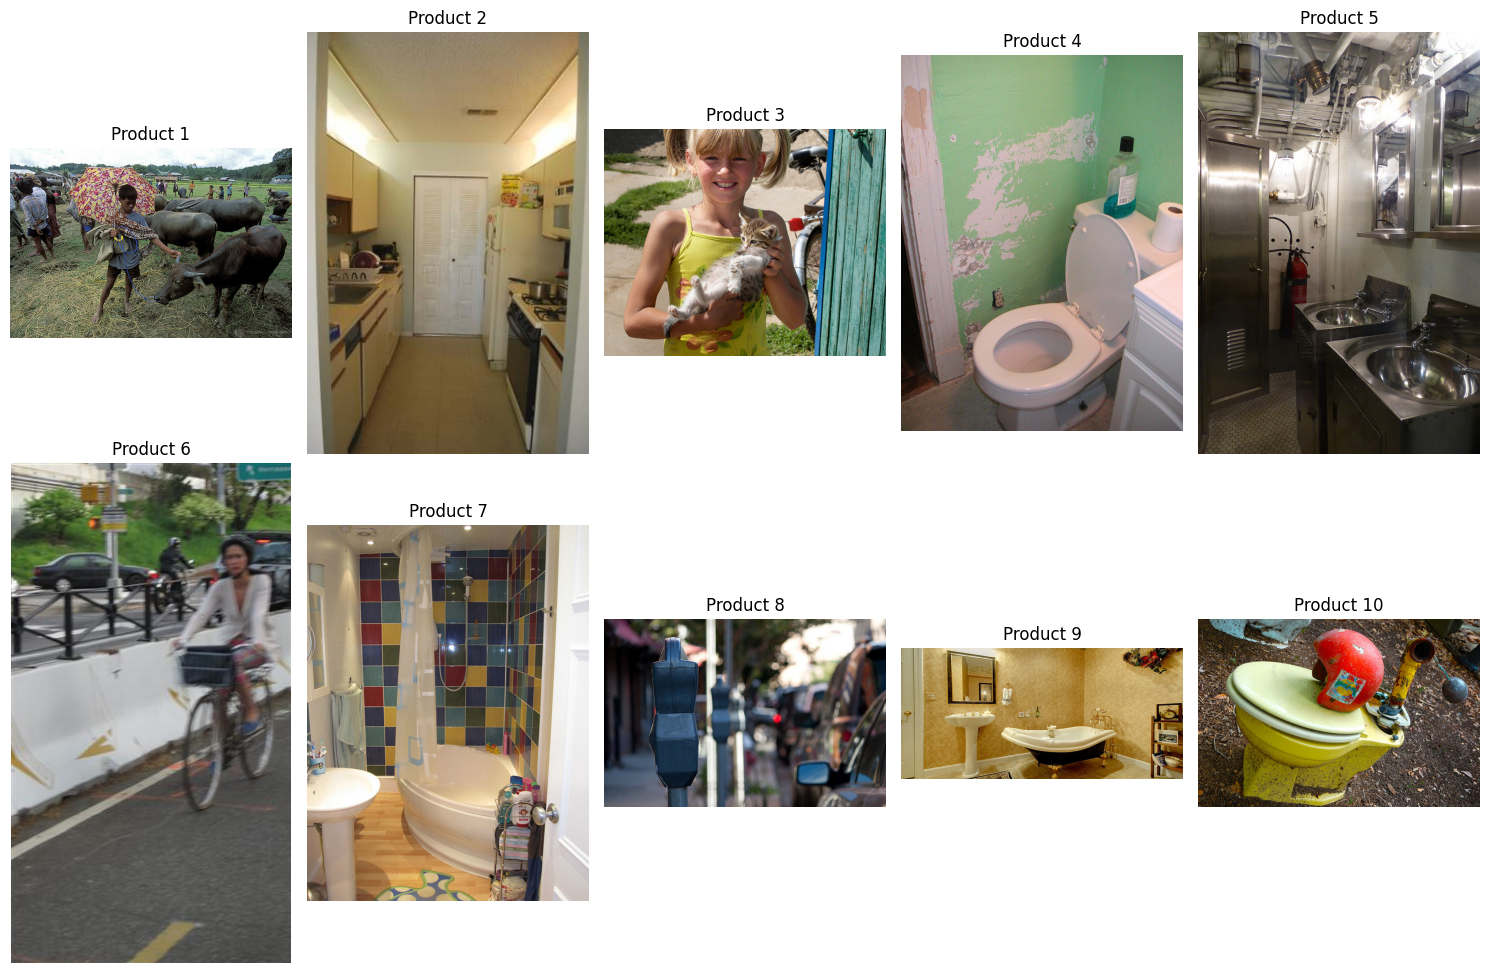


=== Try These Search Queries ===

📝 Query: 'outdoor sports equipment'
  [Search would use CLIP embeddings]

📝 Query: 'person wearing a hat'
  [Search would use CLIP embeddings]

📝 Query: 'colorful objects'
  [Search would use CLIP embeddings]

📝 Query: 'indoor furniture'
  [Search would use CLIP embeddings]


In [13]:
# Simulate a product catalog
print("=== Visual Product Search Demo ===")
print("\nSimulating a product catalog with images from COCO...")

# Load sample images from COCO dataset if not already loaded
if 'images' not in dir() and 'images_pathb' not in dir():
    print("Loading sample images from COCO dataset...")
    # Load COCO validation dataset (small subset)
    coco_dataset = load_dataset("yerevann/coco-karpathy", split="validation[:20]")

    images_pathb = []
    captions_pathb = []

    for i in range(12):
        # Download image from URL
        image_url = coco_dataset[i]['url']
        try:
            response = requests.get(image_url, timeout=10)
            img = Image.open(BytesIO(response.content))
            images_pathb.append(img)

            # Get caption
            sentences = coco_dataset[i]['sentences']
            if isinstance(sentences, list) and len(sentences) > 0:
                if isinstance(sentences[0], dict):
                    captions_pathb.append(sentences[0]['raw'])
                else:
                    captions_pathb.append(sentences[0])
            else:
                captions_pathb.append("No caption available")
        except Exception as e:
            print(f"Failed to load image {i}: {e}")
            continue
    print(f"✓ Loaded {len(images_pathb)} images")


# Use our loaded images as "products"
# Check which path was executed to determine which image variable to use
if 'images' in dir():
    product_images = images[:10]
elif 'images_pathb' in dir():
    product_images = images_pathb[:10]
else:
    product_images = []
    print("No images loaded from either Path A or Path B.")


product_names = [f"Product {i+1}" for i in range(len(product_images))]

# Display the "catalog"
print(f"\nCatalog size: {len(product_images)} products")
show_images(product_images, titles=product_names, cols=5)

# Interactive search
print("\n=== Try These Search Queries ===")
sample_queries = [
    "outdoor sports equipment",
    "person wearing a hat",
    "colorful objects",
    "indoor furniture"
]

for query in sample_queries:
    print(f"\n📝 Query: '{query}'")

    if 'clip_model' in dir():
        # Use CLIP for search
        results = search_images_clip(product_images, query, top_k=3)
        print("Top 3 Results:")
        for rank, (idx, score) in enumerate(results, 1):
            print(f"  {rank}. {product_names[idx]} (score: {score:.3f})")
    else:
        print("  [Search would use CLIP embeddings]")

### 🤔 Reflection Question 6: Architecture Selection

Recall the architecture comparison from the lecture:

| Architecture | Approach | Best For |
|-------------|----------|----------|
| CLIP | Contrastive | Classification, search |
| BLIP | Projector + Gen | VQA, Captioning |
| LLaVA | Projector | Multimodal chat |
| Flamingo | Adapter | Few-shot learning |
| GPT-4V | Integrated | Complex reasoning |

**Question**: For each application below, which VLM architecture would you choose? Explain your reasoning considering:
- Task requirements
- Performance needs
- Cost constraints
- Data availability

**Applications**:
1. **Museum exhibit descriptions**: Generate engaging descriptions of artwork for visitors
2. **E-commerce search**: Let customers find products using natural language
3. **Medical diagnosis assistant**: Help doctors analyze X-rays and generate reports
4. **Social media content moderation**: Flag inappropriate images
5. **Educational chatbot**: Answer student questions about diagrams and figures

**Your Analysis**:
_(For each application, choose an architecture and explain why)_

1. Museum: I would use BLIP since the objective is to generate engaging descriptions of artwork and BLIP is excellent for this purpose.

2. E-commerce: I would use CLIP since the objective is for classification and search. It is an E-commerce so there would need to be a lot of classification work for all the products.

3. Medical: I would use GPT-4V for this since it not only needs to be trained on complex medical data but also needs to do complex reasoning. This would make it a good choice for assisting doctors with analyzing X-rays. The cost may be high but accuracy is important in this case, so it is a decent tradeoff.

4. Moderation: I would use Flamingo for this since it is good at learning to perform tasks with only a few examples, which makes it good for content moderation.

5. Education: I would use LLaVA for the learning tasks since it has a few known advantages of being a chatbot that can discuss visual content. The fact that it is open source means that schools can use it without the need for a huge budget.

---

### Trade-off Analysis: API vs. Self-Hosted

Recall from lecture: **API Services** (GPT-4V, Claude) vs. **Self-Hosted** (CLIP, BLIP, LLaVA)

Let's analyze the trade-offs with real numbers.

In [12]:
# Cost comparison calculator
def compare_deployment_costs(num_images_per_day, days_per_month=30):
    """
    Compare costs between API and self-hosted deployment.
    """
    total_images = num_images_per_day * days_per_month

    # API costs (approximate for GPT-4V as of 2024)
    api_cost_per_image = 0.01  # $0.01 per image (approximate)
    api_total = api_cost_per_image * total_images

    # Self-hosted costs
    gpu_instance_per_month = 500  # $500/month for GPU instance
    development_cost = 5000  # One-time setup cost
    maintenance_per_month = 1000  # Engineering time

    self_hosted_monthly = gpu_instance_per_month + maintenance_per_month
    self_hosted_first_month = self_hosted_monthly + development_cost

    # Analysis
    print("=== Cost Comparison ===")
    print(f"\nScenario: {num_images_per_day:,} images/day = {total_images:,} images/month\n")

    print(f"📱 API Service (e.g., GPT-4V):")
    print(f"   Monthly cost: ${api_total:,.2f}")
    print(f"   Pros: No infrastructure, instant scaling, always up-to-date")
    print(f"   Cons: Usage-based pricing, data privacy concerns\n")

    print(f"🖥️  Self-Hosted (e.g., BLIP on your server):")
    print(f"   First month: ${self_hosted_first_month:,.2f} (includes setup)")
    print(f"   Ongoing monthly: ${self_hosted_monthly:,.2f}")
    print(f"   Pros: Data privacy, customization, fixed costs")
    print(f"   Cons: Infrastructure management, maintenance burden\n")

    # Break-even analysis
    breakeven_months = (self_hosted_first_month - api_total) / (api_total - self_hosted_monthly)
    if breakeven_months > 0:
        print(f"💡 Break-even point: ~{breakeven_months:.1f} months")
        print(f"   After {breakeven_months:.1f} months, self-hosted becomes cheaper.")
    else:
        print(f"💡 At this volume, API service is more cost-effective.")

# Try different scenarios
print("\n=== SCENARIO 1: Small Startup ===")
compare_deployment_costs(num_images_per_day=100)

print("\n" + "="*60)
print("\n=== SCENARIO 2: Medium Business ===")
compare_deployment_costs(num_images_per_day=10000)

print("\n" + "="*60)
print("\n=== SCENARIO 3: Large Enterprise ===")
compare_deployment_costs(num_images_per_day=100000)


=== SCENARIO 1: Small Startup ===
=== Cost Comparison ===

Scenario: 100 images/day = 3,000 images/month

📱 API Service (e.g., GPT-4V):
   Monthly cost: $30.00
   Pros: No infrastructure, instant scaling, always up-to-date
   Cons: Usage-based pricing, data privacy concerns

🖥️  Self-Hosted (e.g., BLIP on your server):
   First month: $6,500.00 (includes setup)
   Ongoing monthly: $1,500.00
   Pros: Data privacy, customization, fixed costs
   Cons: Infrastructure management, maintenance burden

💡 At this volume, API service is more cost-effective.


=== SCENARIO 2: Medium Business ===
=== Cost Comparison ===

Scenario: 10,000 images/day = 300,000 images/month

📱 API Service (e.g., GPT-4V):
   Monthly cost: $3,000.00
   Pros: No infrastructure, instant scaling, always up-to-date
   Cons: Usage-based pricing, data privacy concerns

🖥️  Self-Hosted (e.g., BLIP on your server):
   First month: $6,500.00 (includes setup)
   Ongoing monthly: $1,500.00
   Pros: Data privacy, customization, f

### ✅ Knowledge Check 6: Deployment Decisions

**Question 1**: Based on the cost analysis above, when does self-hosting make sense vs. using an API service?

**Your Answer**:
Self-hosting makes more sense when the company is at a medium to large enterprise level. At the small startup level, it makes more sense to use an API service.

**Question 2**: What other factors (beyond cost) should influence the API vs. self-hosted decision?

**Your Answer**:
Data privacy and reliability are some important factors that should be taken into account for the API vs. self-hosted decision. For example, if doing self-hosted, does the company have the resources to run a SOC to defend against cyber attacks. As for realiability, one could argue that it would be more reliable to go with an API provider, but as the recent AWS outage has shown, even the big cloud providers are not immune from outages.

---

## Section 6: Critical Analysis - Limitations and Ethics

From the lecture, we learned about critical limitations and ethical considerations. Let's explore these hands-on.

### Limitation 1: Hallucinations and Confabulations

VLMs can generate plausible but incorrect descriptions. Let's test this!

=== Testing for Hallucinations ===

Let's ask questions that require counting or reading small text...



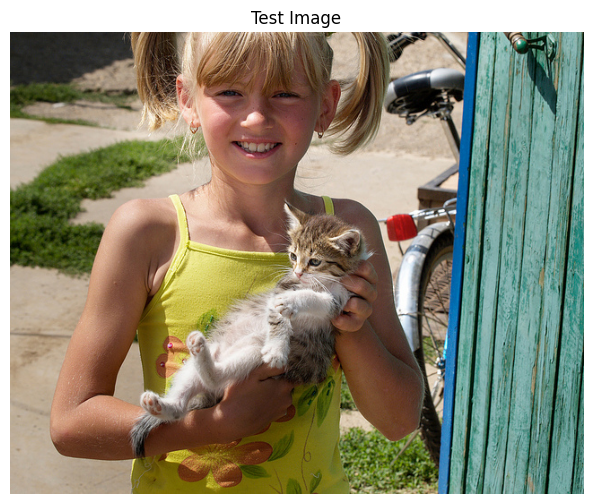

⚠️ VQA model not loaded. Here's what might happen:

Q: How many people are in this image?
A: three  [But there might be 2 or 4!]

Q: What is written on the sign?
A: stop  [But the text is too small to read!]


💡 Observation:
VLMs often provide confident answers even when they can't actually
perform the task (like counting or reading small text).
This is called 'hallucination' - generating plausible but incorrect information.


In [8]:
# Test for hallucinations
print("=== Testing for Hallucinations ===")
print("\nLet's ask questions that require counting or reading small text...\n")

# Choose an image
test_image = product_images[2] if len(product_images) > 2 else product_images[0]

plt.figure(figsize=(8, 6))
plt.imshow(test_image)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Test with challenging questions
if 'blip_vqa_model' in dir():
    challenging_questions = [
        "How many objects are in this image?",
        "What is the exact text written in the image?",
        "What is the person thinking?",
        "What happened right before this photo was taken?"
    ]

    print("Asking challenging questions...\n")
    for q in challenging_questions:
        answer = answer_question_blip(test_image, q)
        print(f"Q: {q}")
        print(f"A: {answer}")
        print()
else:
    print("⚠️ VQA model not loaded. Here's what might happen:\n")
    print("Q: How many people are in this image?")
    print("A: three  [But there might be 2 or 4!]\n")
    print("Q: What is written on the sign?")
    print("A: stop  [But the text is too small to read!]\n")

print("\n💡 Observation:")
print("VLMs often provide confident answers even when they can't actually")
print("perform the task (like counting or reading small text).")
print("This is called 'hallucination' - generating plausible but incorrect information.")

### 🤔 Reflection Question 7: Hallucinations and Trust

**Question**:
1. Why are hallucinations particularly problematic for VLMs in high-stakes applications (medical, legal, safety)?

2. The lecture mentioned that "confidence doesn't correlate with accuracy." What does this mean, and why is it dangerous?


3. How would you design a system to detect or mitigate hallucinations in production?


4. What responsibility do AI developers have to communicate these limitations to users?

**Your Answer**:
1.  VLM hallucinations are dangerous in high-stakes applications because they confidently invent plausible but false information. If a human user takes that into account for their decision making without fact-checking, it could lead to disastrous consequences (such as misdiagnosing diseases, thinking a red light is green).

2.  "Confidence doesn't correlate with accuracy." means that AI can present false information with great confidence and may even double down on being wrong if you ask additional questions. It is dangerous because unless you were doing additional research for fact-checking, you can have completely wrong information from the AI and not be aware of it.

3.  To design a system to detect or mitigate hallucinations in production, here are some steps we could follow:

  Prevent (Grounding): Use Retrieval-Augmented Generation (RAG). Force the AI to base its answer on trusted facts you provide in the prompt, rather than just its internal training.

  Detect (Verification): Automatically review the answer before sending it.
  AI-as-Judge: Use a second AI to check if the first AI's answer is supported by the facts.
  Consistency Check: Ask the same question multiple times. Different answers signal a hallucination.

  Mitigate (Action): Once a hallucination is flagged, act on it.

  Block: Discard the bad answer and reply with a safe message ("I don't know").
  Self-Correct: Ask the AI to try again, but stick only to the facts.
  Human Review: For critical tasks, send the flagged answer to a person to review.

4.  AI developers have the responsibility to communicate the limitations of the models to users in an easy-to-understand and transparent manner (not buried in legalese of the terms and conditions documents).
---

### Limitation 2: Bias and Fairness

VLMs can perpetuate biases present in their training data.

In [11]:
# Conceptual exploration of bias
print("=== Understanding Bias in VLMs ===")
print("""
VLMs are trained on internet data, which contains societal biases.

Examples of potential biases:
1. Gender associations
   - "doctor" -> often associated with male images
   - "nurse" -> often associated with female images

2. Racial and cultural biases
   - Facial recognition works better on some demographics
   - Cultural contexts may be misunderstood

3. Socioeconomic biases
   - Certain lifestyles or settings over-represented
   - Professional settings may be stereotyped

4. Geographic biases
   - Western-centric training data
   - Other cultures under-represented

💡 Why this matters:
- Automated systems can perpetuate discrimination
- Affects real people's lives (hiring, lending, justice)
- Erodes trust in AI systems
- Legal and ethical implications
""")

print("\n=== Testing for Bias (Conceptual) ===")
print("""
To test for bias, you would:
1. Create a diverse test set with balanced demographics
2. Measure performance across different groups
3. Look for disparities in accuracy, caption quality, etc.
4. Analyze associations (what words/concepts cluster together)

Example test:
- Show images of doctors of different genders/races
- Check if the model consistently identifies them as "doctor"
- Or does it use different terms based on appearance?
""")

=== Understanding Bias in VLMs ===

VLMs are trained on internet data, which contains societal biases.

Examples of potential biases:
1. Gender associations
   - "doctor" -> often associated with male images
   - "nurse" -> often associated with female images

2. Racial and cultural biases
   - Facial recognition works better on some demographics
   - Cultural contexts may be misunderstood

3. Socioeconomic biases
   - Certain lifestyles or settings over-represented
   - Professional settings may be stereotyped

4. Geographic biases
   - Western-centric training data
   - Other cultures under-represented

💡 Why this matters:
- Automated systems can perpetuate discrimination
- Affects real people's lives (hiring, lending, justice)
- Erodes trust in AI systems
- Legal and ethical implications


=== Testing for Bias (Conceptual) ===

To test for bias, you would:
1. Create a diverse test set with balanced demographics
2. Measure performance across different groups
3. Look for disparities i

### 🤔 Reflection Question 8: Ethics and Responsibility

Recall the lecture's **Ethical Imperatives**:
- 🔒 **Privacy**: Images contain sensitive information
- 🔍 **Transparency**: Users must understand what's being analyzed
- ⚖️ **Fairness**: Test across diverse demographics
- 👤 **Accountability**: Human oversight for high-stakes decisions

**Question**: Consider a company deploying a VLM for automated resume screening that analyzes candidate photos.

1. What ethical concerns does this raise?
2. What could go wrong? (Think about bias, privacy, transparency)
3. What safeguards would you require before deploying such a system?
4. Should some applications of VLMs be off-limits entirely? Which ones and why?
5. As an AI practitioner, what is your responsibility when asked to build such a system?

**Your Answer**:
1.  The ethical concerns with this implementation would be racial and gender biases. Studies have shown that the same candidates with a "White/Westernized" name on resumes are more likely to received callbacks than when they used their original "Ethnic" name. Similar biases in candidate selection has been shown where male candidates are favored over female candidates.
2.  The model, trained on biases, could simply filter out any candidate who is not a white man. Additionally, there are privacy concerns with storing facial photos of thousands of people. Who would be responsible for disposing the data properly and prevent it from being used for nefarious reasons such as facial recognition for surveillance purposes?
3.  This kind of applications of VLMs, where people's livelihoods are at stakes, and the potential for biases is too high, should be off-limits.
4.  As an AI practitioner, my responsibility is to understand the consequences and be ready to be fired should I refused to build such an unethical system.

---

### Limitation 3: Computational Costs and Environmental Impact

From the lecture: Training costs $50K - $10M, inference takes 1-5 seconds, significant carbon footprint.

In [10]:
# Estimate computational costs
import time

print("=== Computational Cost Analysis ===")

# Measure inference time
test_img = product_images[0]

if 'clip_model' in dir():
    # CLIP inference
    categories = ["a photo of a dog", "a photo of a cat", "a photo of a person"]

    start = time.time()
    for _ in range(10):
        _ = classify_image_clip(test_img, categories)
    end = time.time()

    avg_time = (end - start) / 10
    print(f"\nCLIP inference time: {avg_time*1000:.1f} ms per image")
    print(f"Throughput: {1/avg_time:.1f} images/second")
    print(f"For 1M images: ~{avg_time*1e6/3600:.1f} hours")

elif 'blip_caption_model' in dir():
    # BLIP inference
    start = time.time()
    for _ in range(5):
        _ = generate_caption_blip(test_img)
    end = time.time()

    avg_time = (end - start) / 5
    print(f"\nBLIP inference time: {avg_time*1000:.1f} ms per image")
    print(f"Throughput: {1/avg_time:.1f} images/second")
    print(f"For 1M images: ~{avg_time*1e6/3600:.1f} hours")

print("\n💡 Implications:")
print("- Inference cost scales linearly with usage")
print("- GPU usage -> electricity consumption -> carbon emissions")
print("- Training is FAR more expensive (thousands of GPU-hours)")
print("\nSustainability considerations:")
print("- Use smaller models when possible")
print("- Batch processing for efficiency")
print("- Consider carbon-aware computing (run during low-carbon electricity periods)")
print("- Model distillation (smaller model learns from larger one)")

=== Computational Cost Analysis ===

💡 Implications:
- Inference cost scales linearly with usage
- GPU usage -> electricity consumption -> carbon emissions
- Training is FAR more expensive (thousands of GPU-hours)

Sustainability considerations:
- Use smaller models when possible
- Batch processing for efficiency
- Consider carbon-aware computing (run during low-carbon electricity periods)
- Model distillation (smaller model learns from larger one)


### ✅ Knowledge Check 7: Environmental Responsibility

**Question**: A company wants to process every user-uploaded image through GPT-4V for content analysis. They process 100M images/month. What environmental and cost considerations should they think about? What alternatives might be more sustainable?

**Your Answer**:
Such a huge data processing task would require thousands of GPU-hours, which means putting extra load on the grid, increasing carbon emissions, and increasing water usage for data center cooling. Additionally, there is the privacy concerns to consider. The company should define their goal in what kind of content analysis are they aiming to do exactly, and take a random sampling of images for their training dataset related to their goal, rather than aimleslly trying to do hundreds of millions of images.

---

## Section 7: Synthesis and Final Reflection

Congratulations on making it through the lab! Let's consolidate your learning.

### 🎯 Learning Outcomes Review

Let's check if we've met our learning outcomes:

1. ✅ **Understand VLMs and Their Architectures**
   - You explored CLIP's contrastive learning approach
   - Or BLIP's generation capabilities
   - You understood embeddings and shared representation spaces
   - You learned about different bridging strategies (adapters vs. projectors)

2. ✅ **Understand Applications of VLMs**
   - You implemented zero-shot classification and image search
   - Or caption generation and VQA
   - You explored real-world use cases
   - You built a mini product search system

3. ✅ **Evaluate and Apply**
   - You analyzed architectural trade-offs
   - You compared API vs. self-hosted deployment
   - You evaluated metrics and performance
   - You considered ethical implications and limitations

---

### 🤔 Final Reflection Questions

These questions require you to synthesize everything you've learned. **Take 15-20 minutes to think and write thoughtful answers.**

#### Question 1: Architecture Selection Framework

Create a decision framework for choosing a VLM architecture. Fill in the table:

| If you need... | Consider... | Because... |
|---------------|-------------|------------|
| Zero-shot classification |CLIP |Good for simple search and uses less resources |
| Generate natural descriptions |BLIP |It has excellent bootstrapping tech to generate captions |
| Conversational interaction |LLaVA |Good for multimodal chat |
| Few-shot learning |Flamingo | Good for tasks with limited data |
| Complex reasoning |GPT-4v | Good for complex reasoning and analysis |

**Your Framework**:
_(Fill in the table above)_

---

#### Question 2: Real-World Design Challenge

**Scenario**: A national museum wants to create an interactive mobile app where visitors can:
- Point their camera at any exhibit
- Get a detailed description
- Ask questions about the artwork
- Hear stories and historical context

**Your task**: Design the system. Address:
1. Which VLM architecture(s) would you use? Why?
2. API service or self-hosted? Justify your choice.
3. What data would you need? How would you acquire it?
4. What evaluation metrics matter for this use case?
5. What could go wrong? How would you mitigate risks?
6. How would you ensure accessibility and inclusivity?

**Your Design**:
I would use BLIP for the VQA and the captioning tasks, and LLaVA for the interactive multimodal chat. Depending on the usage, I would start out with the API service and scale to self-hosted VLMs if necessary. The data needed would be the images of the artworks in the museum's collections, so I will need staff to photograph these images, research the historical context, create the content to go with the descriptions that would go along with BLIP's output, and perform quality control.
The performance metrics that would apply for this use case are BLEU and VQA accuracy. Some things that could go wrong: the app returning incorrect captions, hallucinates and giving misinformation to the user when asked about art work. Regular bias audits and extensive testing should hopefully mitigate the risks.
To ensure accessibility and inclusivity I would have audio transcriptions for visually impaired users as well.

---

#### Question 3: Comparing Your Path

**If you did Path A (CLIP)**:
- What are the limitations of CLIP compared to generative models like BLIP?
- For what types of applications is CLIP's approach actually better?
- How would you extend CLIP's capabilities without switching models?

**If you did Path B (BLIP)**:
- What are the trade-offs of generation vs. classification-only models?
- When would CLIP's simpler approach be preferable to BLIP?
- How do the computational costs compare?

**Your Analysis**:
Classification-only models like CLIP are simpler and best suited for image search and zero-shot classification, while generative models like BLIP add complexity to enable sophisticated text generation for tasks like captioning and VQA.

CLIP's simpler, contrastive learning approach is preferable when the primary objective is simple classification, image search, or zero-shot classification.

CLIP would cost less computationally compared to BLIP due to the computational requirements to produce an output.

---

#### Question 4: The Future of VLMs

Based on what you've learned:
1. What do you think is the biggest remaining challenge for VLMs?
2. What new applications of VLMs are you most excited about?
3. What concerns you most about the widespread deployment of VLMs?
4. If you were leading a VLM research team, what would you focus on?

**Your Vision**:
1.  I think the biggest challenge for VLMs is safeguarding the user data. In the US, there is the NIST framework on using AI ethically but it's only a suggestion and not requirements. Compared to European laws, where companies are fined a substantial percent of their profits when they do not employ safeguards for deploying AIs, I think the US laws are too lax. User data gathered by commercial tech companies can be accessed by the government and used for mass  surveillance without our consent (see municipalities and HOAs in Houston and elsewhere voluntarily installing Flock cameras as an example).

2.  I am most excited about using VLMs to offload repetitive and/or tramatic human labor like detecting defects in manufacturing/agriculture and flagging offensive content on social media.

3.  I am most concerned about the lack of regulation with the widespread deployment of VLMs. I have provided an example in #1.

4.	If I were leading a VLM research team, I would be interested in finding ways to flag if an image is AI-generated or not since we have a lot of content these days that are AI-generated or deepfake used to misinform people.

---

#### Question 5: Ethical Leadership

Recall the lecture's **Golden Rule**: "VLMs are powerful assistants, NOT autonomous decision-makers."

**Question**:
1. Why is this distinction important?
2. Give three examples of applications where VLMs should NOT be used autonomously.
3. How would you design "human-in-the-loop" systems for high-stakes decisions?
4. What training or guidelines would you give to people working with VLM outputs?

**Your Answer**:
1.	This distinction is important to remind the user to not outsource all the decision-making to the AI model.

2.	Using VLMs to automatically filter out candidates for job interviews, to diagnose diseases without physician's oversight/QA, or for automatic security surveillance/manhunt

3.	Humans need to be involved throughout the process from checking training/validation data results to monitoring production results. Prior to any major decision making point, a human should be involved, at least in the early stages of training.
4.	I would train them to recognize social and personal biases they might have that could impact the data and model performance.

---

## Summary and Next Steps

### 🎓 What You've Accomplished

In this lab, you:
- ✅ Understood how VLMs create shared embedding spaces for vision and language
- ✅ Implemented zero-shot classification and image search (CLIP) OR caption generation and VQA (BLIP)
- ✅ Explored model architectures and learned about fine-tuning concepts
- ✅ Evaluated VLM performance using appropriate metrics
- ✅ Analyzed real-world applications and deployment trade-offs
- ✅ Critically examined limitations, biases, and ethical considerations
- ✅ Synthesized knowledge to make informed architectural decisions

### 📚 Additional Resources

To deepen your understanding:

**Papers to Read**:
- [CLIP Paper](https://arxiv.org/abs/2103.00020): "Learning Transferable Visual Models From Natural Language Supervision"
- [BLIP Paper](https://arxiv.org/abs/2201.12086): "BLIP: Bootstrapping Language-Image Pre-training"
- [LLaVA Paper](https://arxiv.org/abs/2304.08485): "Visual Instruction Tuning"

**Interactive Demos**:
- [Hugging Face Spaces](https://huggingface.co/spaces): Try CLIP, BLIP, and LLaVA demos
- [OpenAI CLIP](https://openai.com/research/clip): Official CLIP demo

**Datasets to Explore**:
- [COCO Dataset](https://cocodataset.org/): Image captioning and detection
- [Flickr30k](http://hockenmaier.cs.illinois.edu/Flickr30kEntities/): Image-caption pairs
- [Visual Genome](https://visualgenome.org/): Detailed scene understanding

**Practice Projects**:
1. Build a visual search engine for your photo library
2. Create an accessibility tool that describes images for screen readers
3. Fine-tune CLIP on a specific domain (e.g., medical images, satellite imagery)
4. Implement a bias detection tool for VLM outputs

### 🚀 Challenge: Extend This Lab

Try one of these extensions:
1. **Implement the other path**: If you did Path A, try Path B (or vice versa)
2. **Add data augmentation**: Improve robustness by testing with modified images
3. **Build a GUI**: Create a simple web interface using Gradio or Streamlit
4. **Conduct a bias audit**: Test your model on diverse images and measure fairness metrics
5. **Implement caching**: Speed up repeated queries with embedding caching

---

### 🙏 Thank You!

You've completed a comprehensive exploration of Visual Language Models. Remember:

- **VLMs are powerful tools**, but they're not magic - understand their capabilities AND limitations
- **Always evaluate critically** - high confidence doesn't mean high accuracy
- **Consider ethics first** - your decisions as an AI practitioner affect real people
- **Keep learning** - this field evolves rapidly!

**Questions or feedback?** Discuss with your instructor and classmates.

---

*Lab by Patricia McManus for ITAI 1378 - Module 08: Visual Language Models*